In [1]:
import tstrippy
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# make some pouliasis params 
unitM = u.Msun
unitL = u.kpc
unitV = u.km / u.s
unitG = unitL*unitV**2 / unitM
G = const.G.to(unitG).value
Mass,a,gamma,rcut = 1e11, 14, 2.02,100
params = [G, Mass, a, gamma, rcut]
# make some points
r = np.linspace(0.1, 1500, 1000) 

In [3]:
ax,ay,az,phi = tstrippy.potentials.allensantillianhalo(params,r,np.zeros_like(r),np.zeros_like(r))

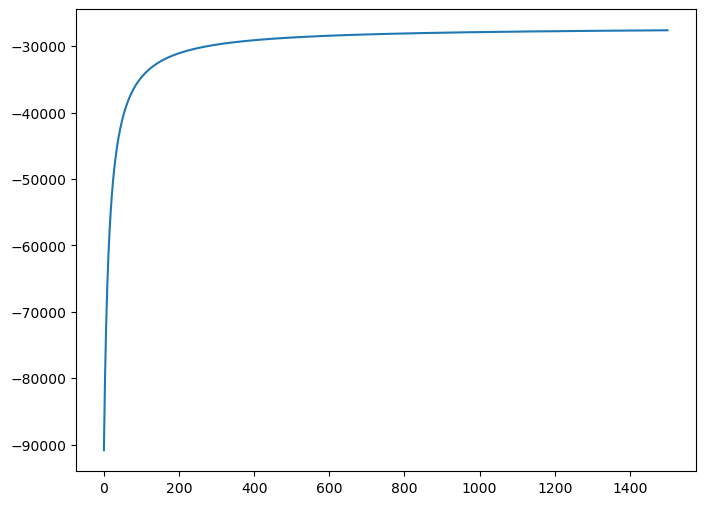

In [6]:
fig,axis=plt.subplots(1,1,figsize=(8,6))
axis.plot(r,phi, label='ax') 

In [32]:
def force(x,y,z,params):
    G, Mass, a, gamma, rcut = params
    r=np.sqrt(x**2 + y**2 + z**2)
    outside = r > rcut
    x = r/a
    xc = rcut/a
    amod = -(G*Mass/a**3) * (x**(gamma-3)) / (1+x**(gamma-1))
    amod[outside] = -(G*Mass/(r[outside]**3)) * (xc**gamma) / (1+xc**(gamma-1))
    return amod

In [39]:
r=np.linspace(0, 150, 1000)
amod=force(r,np.zeros_like(r),np.zeros_like(r),params)


/tmp/ipykernel_3630998/522350782.py:7: RuntimeWarning: divide by zero encountered in power
  amod = -(G*Mass/a**3) * (x**(gamma-3)) / (1+x**(gamma-1))


/tmp/ipykernel_3630998/3993296584.py:2: RuntimeWarning: invalid value encountered in multiply
  axis.plot(r,amod*r, label='ax')


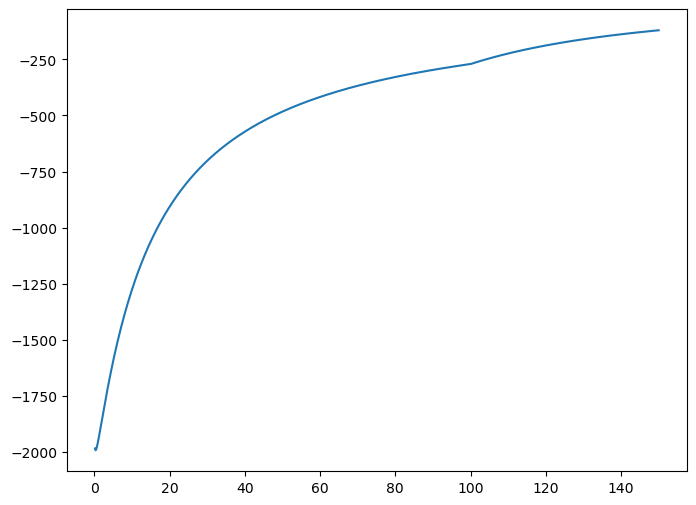

In [37]:
fig,axis=plt.subplots(1,1,figsize=(8,6))
axis.plot(r,amod*r, label='ax')